### Return variance at news arrival during trading and non-trading hours.

References: 
- Boudoukh, Feldman, Kogan, Richardson (2019) - Information, Trading, and Volatility: Evidence from Firm-Specific News  
- French, K. R., and R. Roll. 1986. Stock return variances: The arrival of information and reaction of traders.

In [14]:
%%capture
import sys
import math
import random
import pickle
import matplotlib
import pandas as pd
import numpy as np
import scipy
import datetime as dt
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import regex as re
#from numpy import *
from scipy import stats
from scipy.stats import ttest_1samp
from datetime import timedelta, datetime, time, date
from statsmodels.regression.linear_model import RegressionResults
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import rc
from tqdm.notebook import tqdm
from cycler import cycler
tqdm().pandas()

fontsize = 12
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': fontsize})
rc('text', usetex=True)

color_list = ["#348ABD","#A60628","#7A68A6","#467821","#CF4457","#188487","#E24A33"]
style = {
  "lines.linewidth": 2.0,
  "axes.edgecolor": "#bcbcbc",
  "patch.linewidth": 0.5,
  "legend.fancybox": True,
  "axes.prop_cycle": cycler('color', color_list),
  "axes.facecolor": "#ffffff",
  "axes.labelsize": "large",
  "axes.grid": True,
  "patch.edgecolor": "#eeeeee",
  "axes.titlesize": "x-large",
  "svg.fonttype": "path"}

matplotlib.rcParams.update(style)

# Modify pandas display settings
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 30)

data_path       = "C:/Users/Stefa/Documents/Uni/Projektassistenz/Python/Data/"
path_data_files = '/Users/Stefa/Documents/Sentiment Analysis Files/'
save_path       = "C:/Users/Stefa/Documents/Uni/Projektassistenz/Paper II SHORT TERM REVERSAL/Auswertung/"

extended_model_path = data_path+'Classification/DagoBERT/SCE_Loss_minw_25_lr_5e5_3ep_bs32_wd_1e2_a0_5_b3_NN1_w2v_topics/' 
extended_data_path  = path_data_files+'filtered_news_data_for_transformer/train_validation_data' #data_with_922_constituents/train_validation_data/'

output_path   = "C:/Users/Stefa/Documents/Uni/Projektassistenz/Auswertung/"
fin_data_path = "C:/Users/Stefa/Documents/Uni/Projektassistenz/Financial Data/"    


def load_data(file):
    df = pd.read_csv(file, encoding='utf-8-sig')
    df.Date = pd.to_datetime(df.Date)
    df = df.set_index(['Ticker', 'Date'])
    df = df.rename(columns={'Prediction value': 'prediction_value'})
    return df

Load Data

In [2]:
# Return Data
daytime_returns = pd.read_csv(fin_data_path+'Datastream/Data/return_mo_to_mc_idiosync.csv', index_col=0)           
daytime_returns.index = pd.to_datetime(daytime_returns.index)                                                        
daytime_returns = daytime_returns.replace([np.inf, -np.inf, 0.00000], np.nan)              
daytime_returns = daytime_returns[daytime_returns.apply(lambda x: sum(x.isna()), axis=1) < 0.8*daytime_returns.shape[1]] # Drop rows with more than 80% NaN values
daytime_returns = daytime_returns.stack(dropna=True, level=0)
daytime_returns.index.names = ['Date', 'Ticker']
daytime_returns.name = 'Return'
daytime_returns = daytime_returns.reset_index()

overnight_returns = pd.read_csv(fin_data_path+'Datastream/Data/return_mc_to_mo_idiosync.csv', index_col=0)           
overnight_returns.index = pd.to_datetime(overnight_returns.index)                                                        
overnight_returns = overnight_returns.replace([np.inf, -np.inf, 0.00000], np.nan)              
overnight_returns = overnight_returns[overnight_returns.apply(lambda x: sum(x.isna()), axis=1) < 0.8*overnight_returns.shape[1]] # Drop rows with more than 80% NaN values
overnight_returns = overnight_returns.stack(dropna=True, level=0)
overnight_returns.index.names = ['Date', 'Ticker']
overnight_returns.name = 'Return'
overnight_returns = overnight_returns.reset_index()

# z-scores
daytime_z_scores = pd.read_csv(fin_data_path+f'z_values_mo_to_mc_127d_rw_idiosync_2022.csv', encoding='utf-8', index_col=0)      
daytime_z_scores.index = pd.to_datetime(daytime_z_scores.index)       
daytime_z_scores = daytime_z_scores.stack(dropna=True)
daytime_z_scores.index.names = ['Date', 'Ticker']
daytime_z_scores.name = 'z_score'
daytime_z_scores = daytime_z_scores.reset_index()

overnight_z_scores = pd.read_csv(fin_data_path+f'z_values_mc_to_mo_127d_rw_idiosync_2022.csv', encoding='utf-8', index_col=0)      
overnight_z_scores.index = pd.to_datetime(overnight_z_scores.index)       
overnight_z_scores = overnight_z_scores.stack(dropna=True)
overnight_z_scores.index.names = ['Date', 'Ticker']
overnight_z_scores.name = 'z_score'
overnight_z_scores = overnight_z_scores.reset_index()

# News Events
news_events = pd.read_csv("./Data/news_event_df.csv", encoding='utf-8')
news_events.Timestamp_ET = pd.to_datetime(news_events.Timestamp_ET)
news_events.TradingDate = pd.to_datetime(news_events.TradingDate)
news_events.Date = pd.to_datetime(news_events.Date)

daytime_news = news_events.loc[((news_events.Timestamp_ET.dt.time >= time(9,30)) & (news_events.Timestamp_ET.dt.time <= time(16,0)))==True]
daytime_news = daytime_news.loc[:, ['Ticker', 'Date', 'Sentiment', 'topic_1', 'topic_2']]

overnight_news = pd.read_csv("./Data/news_event_df_no_dupl.csv", encoding='utf-8', index_col=0)
overnight_news.Date = pd.to_datetime(overnight_news.Date)
overnight_news = overnight_news.loc[:, ['Ticker', 'Date', 'Sentiment', 'topic_1', 'topic_2']]

In [3]:
use_zscores = True

def events_df(use_zscores, start_date, end_date):
    if use_zscores:
        daytime_df, overnight_df = daytime_z_scores, overnight_z_scores
    else:
        daytime_df, overnight_df = daytime_returns, overnight_returns     
        
    daytime_events   = pd.merge(left=daytime_df,   right=daytime_news,   on=['Date', 'Ticker'], how='left')
    overnight_events = pd.merge(left=overnight_df, right=overnight_news, on=['Date', 'Ticker'], how='left')
    
    daytime_events   = daytime_events.loc[((daytime_events.Date >= start_date) & (daytime_events.Date <= end_date)), :].reset_index(drop=True)
    overnight_events = overnight_events.loc[((overnight_events.Date >= start_date) & (overnight_events.Date <= end_date)), :].reset_index(drop=True)

    if use_zscores:
        daytime_events['Quantil']   = pd.qcut((daytime_events.z_score**2).values,   q=10, labels=[f'Quantile_{i}' for i in range(1, 10+1)])
        overnight_events['Quantil'] = pd.qcut((overnight_events.z_score**2).values, q=10, labels=[f'Quantile_{i}' for i in range(1, 10+1)])                 
    else:
        daytime_events['Quantil']   = pd.qcut((daytime_events.Return**2).values,   q=10, labels=[f'Quantile_{i}' for i in range(1, 10+1)])
        overnight_events['Quantil'] = pd.qcut((overnight_events.Return**2).values, q=10, labels=[f'Quantile_{i}' for i in range(1, 10+1)])  

    return daytime_events, overnight_events
    
    
    
daytime_events, overnight_events = events_df(use_zscores, start_date=datetime(2002,1,1), end_date=datetime(2019,12,31))

**Hypothesis H0: There is no difference in volatility at days (nights) with or without news arrival.**

In [6]:
def calc_intensity(events_df, use_zscores, return_rank=None, return_q_counts=False):
    response_var = 'z_score' if use_zscores else 'Return'
    ratios, q_counts, var_ratio, p_value, n_obs = {}, {}, {}, {}, {}
    cases = {'Total':       slice(None),
             'No News':     events_df.Sentiment.isna(),
             'News':        events_df.Sentiment.notna(),
             'Strong News': abs(events_df.Sentiment) > 0.90,
             'Strong News of Topic 1': ((abs(events_df.Sentiment) > 0.90) & (events_df.topic_1 >= 0.25)),
             'Strong News of Topic 2': ((abs(events_df.Sentiment) > 0.90) & (events_df.topic_2 >= 0.25)),
            }    
    
    r_0 = events_df.loc[cases['No News'], response_var]
    
    for case_i in cases:
        q_counts[case_i] = events_df.loc[cases[case_i], 'Quantil'].value_counts().sort_index()
        
        if return_rank == 'low':
            low_40_null = 4/10
            low_40 = (q_counts[case_i]['Quantile_1'] + 
                      q_counts[case_i]['Quantile_2'] +
                      q_counts[case_i]['Quantile_3'] + 
                      q_counts[case_i]['Quantile_4'])/q_counts[case_i].sum()
            ratios[case_i] = (low_40-low_40_null)/low_40_null           

        elif return_rank == 'moderate':
            moderate_40_null = 4/10
            moderate_40 = (q_counts[case_i]['Quantile_5'] + 
                           q_counts[case_i]['Quantile_6'] +
                           q_counts[case_i]['Quantile_7'] + 
                           q_counts[case_i]['Quantile_8'])/q_counts[case_i].sum()
            ratios[case_i] = (moderate_40-moderate_40_null)/moderate_40_null
            
        elif return_rank == 'extreme':
            extreme_20_null = 2/10
            extreme_20 = (q_counts[case_i]['Quantile_9'] + 
                          q_counts[case_i]['Quantile_10'])/q_counts[case_i].sum()
            ratios[case_i] = (extreme_20-extreme_20_null)/extreme_20_null
        
        elif return_rank == None:
            pass
        
        # Variance Ratio
        r_i = events_df.loc[cases[case_i], response_var]
        var_ratio[case_i] =  r_i.var()/r_0.var()
        dfi, df0 = len(r_i)-1, len(r_0)-1
        p_value[case_i] = 1 - scipy.stats.f.cdf(var_ratio[case_i], dfi, df0)  
        n_obs[case_i]   = q_counts[case_i].sum()

    if return_q_counts:
        return q_counts 
    else:        
        return ratios, var_ratio, p_value, n_obs

In [7]:
start_date = datetime(2002,1,1)
end_date   = datetime(2020,12,31)

cases  = ['Total', 'No News', 'News', 'Strong News', 'Strong News of Topic 1', 'Strong News of Topic 2']    
panels = {'Panel A: Daytime'  :daytime_events.loc[((daytime_events.Date >= start_date)     & (daytime_events.Date <  end_date))], 
          'Panel B: Overnight':overnight_events.loc[((overnight_events.Date >= start_date) & (overnight_events.Date <  end_date))]}

iterables  = [panels.keys(), cases]
index      = pd.MultiIndex.from_product(iterables, names=["Panel", "Case"])
results_df = pd.DataFrame(index=index, columns=['Extreme 20% (%)', 'Moderate 40% (%)', 'Low 40% (%)'], dtype='float64')

for panel in panels.keys():
    _, var_ratio, p_val, n_obs                               = calc_intensity(panels[panel], use_zscores, return_rank=None)
    results_df.loc[(panel, slice(None)), 'Extreme 20% (%)']  = list(calc_intensity(panels[panel], use_zscores, return_rank='extreme')[0].values())
    results_df.loc[(panel, slice(None)), 'Moderate 40% (%)'] = list(calc_intensity(panels[panel], use_zscores, return_rank='moderate')[0].values())
    results_df.loc[(panel, slice(None)), 'Low 40% (%)']      = list(calc_intensity(panels[panel], use_zscores, return_rank='low')[0].values())
    results_df.loc[(panel, slice(None)), 'Var Ratio']        = list(np.array(list(var_ratio.values()))/100)
    results_df.loc[(panel, slice(None)), 'p-value (%)']      = list(np.array(list(p_val.values())))
    results_df.loc[(panel, slice(None)), 'n_obs']            = list(np.array(list(n_obs.values()))/100)
    
(results_df*100).round(2)

Extreme 20% (%)  Moderate 40% (%)  \
Panel              Case                                                        
Panel A: Daytime   Total                              0.00             -0.00   
                   No News                           -1.20              0.20   
                   News                              35.65             -5.99   
                   Strong News                       84.42            -14.55   
                   Strong News of Topic 1            94.97            -15.63   
                   Strong News of Topic 2           142.12            -26.91   
Panel B: Overnight Total                             -0.00             -0.00   
                   No News                           -4.07              0.76   
                   News                              80.23            -15.03   
                   Strong News                      182.77            -39.22   
                   Strong News of Topic 1           159.35            -31.07   
                   Strong News of Topic 2           238.68            -53.64   

                                           Low 40% (%)  Var Ratio  \
Panel              Case                                             
Panel A: Daytime   Total                         -0.00       1.03   
                   No News                        0.40       1.00   
                   News                         -11.84       1.97   
                   Strong News                  -27.66       3.45   
                   Strong News of Topic 1       -31.86       3.11   
                   Strong News of Topic 2       -44.15       4.81   
Panel B: Overnight Total                          0.00       1.31   
                   No News                        1.27       1.00   
                   News                         -25.08       7.37   
                   Strong News                  -52.17      17.26   
                   Strong News of Topic 1       -48.60       7.31   
                   Strong News of Topic 2       -65.70      22.29   

                                           p-value (%)      n_obs  
Panel              Case                                            
Panel A: Daytime   Total                           0.0  3206603.0  
                   No News                        50.0  3102406.0  
                   News                            0.0   104197.0  
                   Strong News                     0.0    33787.0  
                   Strong News of Topic 1          0.0     5452.0  
                   Strong News of Topic 2          0.0     6410.0  
Panel B: Overnight Total                           0.0  3275806.0  
                   No News                        50.0  3117794.0  
                   News                            0.0   158012.0  
                   Strong News                     0.0    50437.0  
                   Strong News of Topic 1          0.0     9811.0  
                   Strong News of Topic 2          0.0    22775.0

In [15]:
# Write df to latex
filename = "volatility_analysis_day_vs_night_z_scores" 

with open(save_path+f"tables/{filename}.tex",'w') as tf:
    tf.write((results_df*100).round(2).to_latex()) 

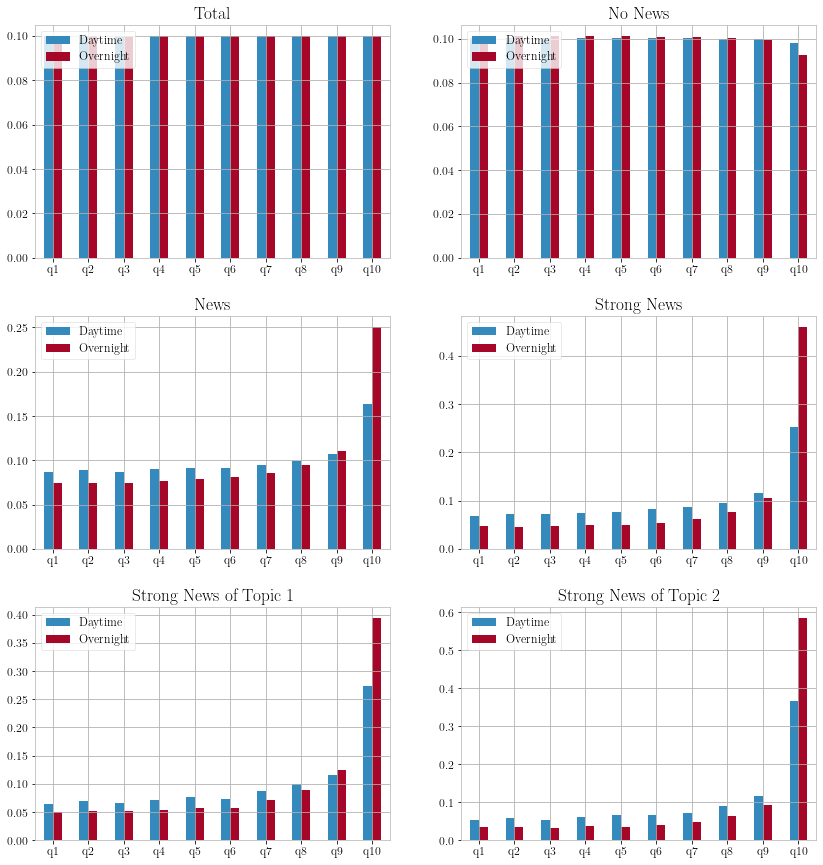

In [10]:
export = False
q_counts_day   = pd.DataFrame.from_dict(calc_intensity(daytime_events.loc[((daytime_events.Date >= start_date) & (daytime_events.Date < end_date))],   
                                                       use_zscores, return_rank=None, return_q_counts=True))
q_counts_night = pd.DataFrame.from_dict(calc_intensity(overnight_events.loc[((overnight_events.Date >= start_date) & (overnight_events.Date < end_date))], 
                                                       use_zscores, return_rank=None, return_q_counts=True))

ticks       = [i for i in range(0, 10)]
tick_labels = [f'q{i}' for i in range(1, 10+1)]

fig, axes = plt.subplots(3,2, figsize=(14,15))
fig.subplots_adjust(hspace=0.25)

for i, case_i in enumerate(cases):
    k, j = math.floor(i/2), i%2
    temp = pd.concat([q_counts_day[case_i], q_counts_night[case_i]], axis=1)
    temp.columns = ['Daytime', 'Overnight']
    temp = temp.divide(temp.sum(axis=0), axis=1)
    temp.plot.bar(ax=axes[k,j], legend=False)
    axes[k,j].legend(loc='upper left')
    axes[k,j].set_xticks(ticks, labels=tick_labels, rotation=0)
    axes[k,j].set_title(case_i)  
    

if export:
    plt.savefig(save_path+'plots/return_volatility_day_vs_night_z_scores'+'_'+datetime.now().strftime("%Hh%Mm%Ss")+'.pdf', bbox_inches='tight')
plt.show()

**Hypothesis H0: The daytime volatility is unaffected by overnight news**

In [10]:
z_scores = pd.read_csv(fin_data_path+f'z_values_mo_to_mc_127d_rw_idiosync_2022.csv', encoding='utf-8', index_col=0)      
z_scores.index = pd.to_datetime(z_scores.index)       
z_scores = z_scores.stack(dropna=True)
z_scores.index.names = ['Date', 'Ticker']
z_scores.name = 'z_score'
z_scores = z_scores.reset_index()

In [12]:
# Add column with z_values(t-1) from z_values(t)
alldates = np.unique(z_scores.Date)
alldates = pd.DataFrame(data={'Date':alldates, 'Date_Index': np.arange(0, len(alldates))})
temp1 = pd.merge(left=z_scores, right=alldates, on='Date', how='left')
temp1 = temp1.rename(columns={'z_score':'z_score_tm1'})
temp1 = temp1[['Ticker', 'Date_Index', 'z_score_tm1']]
temp1 = temp1.set_index(['Date_Index', 'Ticker'])

z_scores = pd.merge(left=z_scores, right=alldates, on='Date', how='left')
z_scores['Date_Index_Merge'] = z_scores.Date_Index-1
z_scores = pd.merge(left=z_scores, right=temp1, left_on=['Date_Index_Merge', 'Ticker'], right_index=True, how='left')
z_scores = z_scores.drop(['Date_Index', 'Date_Index_Merge'], axis=1)

In [13]:
use_zscores = True
start_date  = datetime(2002,1,1)
end_date    = datetime(2019,12,31)

overnight_events2 = pd.merge(left=z_scores, right=overnight_news, on=['Date', 'Ticker'], how='left')
overnight_events2 = overnight_events2.loc[((overnight_events2.Date >= start_date) & (overnight_events2.Date <= end_date)), :].reset_index(drop=True)
overnight_events2['Quantil'] = pd.qcut((abs(overnight_events2.z_score)).values, q=10, labels=[f'Quantile_{i}' for i in range(1, 10+1)])

In [15]:
cases  = ['Total', 'No News', 'News', 'Strong News', 'Strong News of Topic 1', 'Strong News of Topic 2']    
panels = {'Panel C: Overnight News, Daytime Returns': overnight_events2}
#panels = {'Panel C: Overnight News, Daytime Returns': overnight_events2.loc[abs(overnight_events2.z_score_tm1) > 1]}


iterables  = [panels.keys(), cases]
index      = pd.MultiIndex.from_product(iterables, names=["Panel", "Case"])
results_df = pd.DataFrame(index=index, columns=['Extreme 20% (%)', 'Moderate 40% (%)', 'Low 40% (%)'], dtype='float64')

for panel in panels.keys():
    _, var_ratio, p_val, n_obs                               = calc_intensity(panels[panel], use_zscores, return_rank=None)
    results_df.loc[(panel, slice(None)), 'Extreme 20% (%)']  = list(calc_intensity(panels[panel], use_zscores, return_rank='extreme')[0].values())
    results_df.loc[(panel, slice(None)), 'Moderate 40% (%)'] = list(calc_intensity(panels[panel], use_zscores, return_rank='moderate')[0].values())
    results_df.loc[(panel, slice(None)), 'Low 40% (%)']      = list(calc_intensity(panels[panel], use_zscores, return_rank='low')[0].values())
    results_df.loc[(panel, slice(None)), 'Var Ratio']        = list(np.array(list(var_ratio.values()))/100)
    results_df.loc[(panel, slice(None)), 'p-value (%)']      = list(np.array(list(p_val.values())))
    results_df.loc[(panel, slice(None)), 'n_obs']            = list(np.array(list(n_obs.values()))/100)
    
(results_df*100).round(2)

Extreme 20% (%)  \
Panel                                    Case                                      
Panel C: Overnight News, Daytime Returns Total                              0.00   
                                         No News                           -2.23   
                                         News                              43.45   
                                         Strong News                      100.42   
                                         Strong News of Topic 1            48.51   
                                         Strong News of Topic 2           158.38   

                                                                 Moderate 40% (%)  \
Panel                                    Case                                       
Panel C: Overnight News, Daytime Returns Total                              -0.00   
                                         No News                             0.36   
                                         News                               -7.04   
                                         Strong News                       -17.41   
                                         Strong News of Topic 1             -3.19   
                                         Strong News of Topic 2            -30.67   

                                                                 Low 40% (%)  \
Panel                                    Case                                  
Panel C: Overnight News, Daytime Returns Total                          0.00   
                                         No News                        0.75   
                                         News                         -14.68   
                                         Strong News                  -32.80   
                                         Strong News of Topic 1       -21.06   
                                         Strong News of Topic 2       -48.52   

                                                                 Var Ratio  \
Panel                                    Case                                
Panel C: Overnight News, Daytime Returns Total                        1.05   
                                         No News                      1.00   
                                         News                         1.98   
                                         Strong News                  3.30   
                                         Strong News of Topic 1       1.74   
                                         Strong News of Topic 2       4.82   

                                                                 p-value (%)  \
Panel                                    Case                                  
Panel C: Overnight News, Daytime Returns Total                           0.0   
                                         No News                        50.0   
                                         News                            0.0   
                                         Strong News                     0.0   
                                         Strong News of Topic 1          0.0   
                                         Strong News of Topic 2          0.0   

                                                                     n_obs  
Panel                                    Case                               
Panel C: Overnight News, Daytime Returns Total                   3203054.0  
                                         No News                 3046510.0  
                                         News                     156544.0  
                                         Strong News               50040.0  
                                         Strong News of Topic 1     9720.0  
                                         Strong News of Topic 2    22639.0

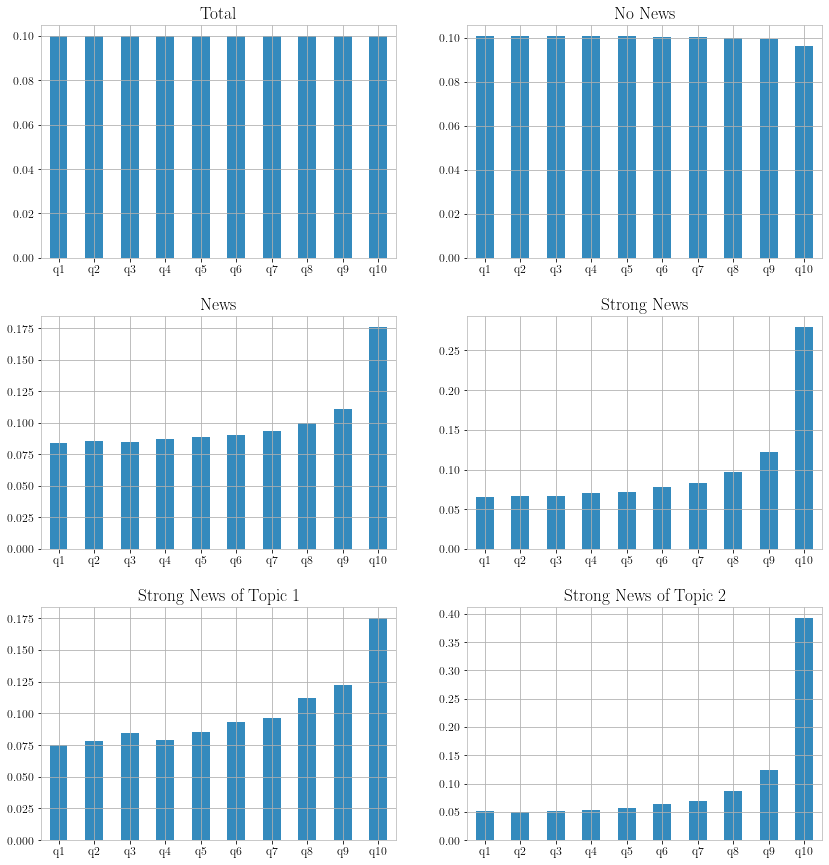

In [16]:
q_counts_night = pd.DataFrame.from_dict(calc_intensity(overnight_events2, use_zscores, return_rank=None, return_q_counts=True))

ticks       = [i for i in range(0, 10)]
tick_labels = [f'q{i}' for i in range(1, 10+1)]

fig, axes = plt.subplots(3,2, figsize=(14,15))
fig.subplots_adjust(hspace=0.25)

for i, case_i in enumerate(cases):
    k, j = math.floor(i/2), i%2
    temp = q_counts_night[case_i]
    temp.columns = ['Overnight News']
    temp = temp.divide(temp.sum(axis=0))
    temp.plot.bar(ax=axes[k,j])
    axes[k,j].set_xticks(ticks, labels=tick_labels, rotation=0)
    axes[k,j].set_title(case_i)  
plt.show()

**Correlation between overnight and daytime returns**

In [117]:
daytime_events, overnight_events = events_df(use_zscores=False, start_date=datetime(2002,1,1), end_date=datetime(2019,12,31))

In [120]:
events = pd.merge(left=overnight_events, right=daytime_events, on=['Ticker', 'Date'], how='inner')
cols = [re.sub(r'_x', '_night', x) for x in events.columns]
cols = [re.sub(r'_y', '_day', x) for x in cols]
events.columns = cols

In [153]:
events.loc[:, ['Return_night', 'Return_day']].corr()
#events.loc[abs(events.Sentiment_night) < 0.45, ['Return_night', 'Return_day']].corr()

,Return_night,Return_day
Return_night,1.000000,-0.190649
Return_day,-0.190649,1.000000


**Variance Decomposition**

In [21]:
# Return Data
daily_returns = pd.read_csv(fin_data_path+'Datastream/Data/return_mc_to_mc_idiosync.csv', index_col=0)           
daily_returns.index = pd.to_datetime(daily_returns.index)                                                        
daily_returns = daily_returns.replace([np.inf, -np.inf, 0.00000], np.nan)              
daily_returns = daily_returns[daily_returns.apply(lambda x: sum(x.isna()), axis=1) < 0.8*daily_returns.shape[1]] # Drop rows with more than 80% NaN values
daily_returns = daily_returns.stack(dropna=True, level=0)
daily_returns.index.names = ['Date', 'Ticker']
daily_returns.name = 'Return'
daily_returns = daily_returns.reset_index()

daily_returns['Variance'] = daily_returns.Return**2
daily_returns = pd.merge(left=daily_returns, right=overnight_news, on=['Ticker', 'Date'], how='left')
daily_returns = pd.merge(left=daily_returns, right=daytime_news,   on=['Ticker', 'Date'], how='left')

cols = [re.sub(r'_x', '_night', x) for x in daily_returns.columns]
cols = [re.sub(r'_y', '_day', x) for x in cols]
daily_returns.columns = cols


daily_returns = daily_returns.loc[((daily_returns.Sentiment_night.notna()) | (daily_returns.Sentiment_day.notna()))].copy() # Select events with news sentiment
daily_returns = daily_returns.replace(np.nan, 0)
daily_returns.insert(2, 'Intercept', 1)

In [22]:
sCrit = 0.45

def dummy_variable(x, limit):
    if abs(x) > limit:
        return 1
    else:
        return 0
    
daily_returns['abs(Sentiment_night)'] = daily_returns.Sentiment_night.apply(dummy_variable, args=([sCrit]))
daily_returns['abs(Sentiment_day)']   = daily_returns.Sentiment_day.apply(dummy_variable, args=([sCrit]))
daily_returns['NoNews_day']           = daily_returns.Sentiment_day.apply(lambda x: 1 if x == 0 else 0)
daily_returns['NoNews']               = daily_returns.loc[:,['abs(Sentiment_night)', 'abs(Sentiment_day)']].sum(axis=1).apply(lambda x: 1 if x == 0 else 0)

In [23]:
daily_returns.head()

,Date,Ticker,Intercept,Return,Variance,Sentiment_night,topic_1_night,topic_2_night,Sentiment_day,topic_1_day,topic_2_day,abs(Sentiment_night),abs(Sentiment_day),NoNews_day,NoNews
55,2002-01-03,APA,1,-0.044841,0.002011,0.0,0.0,0.0,-0.960640,0.265517,0.129310,0,1,0,0
113,2002-01-03,BNI,1,0.021744,0.000473,0.0,0.0,0.0,0.994271,0.000000,0.000000,0,1,0,0
160,2002-01-03,CI,1,-0.009590,0.000092,0.0,0.0,0.0,0.358863,0.000000,0.193966,0,0,0,1
192,2002-01-03,CSCO,1,0.061215,0.003747,0.0,0.0,0.0,0.991981,0.000000,0.202586,0,1,0,0
216,2002-01-03,DIS,1,0.021452,0.000460,0.0,0.0,0.0,-0.997268,0.000000,0.193966,0,1,0,0


In [25]:
#ticker = 'ALB'
features = ['Intercept', 'abs(Sentiment_night)', 'abs(Sentiment_day)']
#features = ['Intercept', 'topic_1_night', 'topic_2_night', 'topic_1_day', 'topic_2_day', 'abs(Sentiment_night)', 'abs(Sentiment_day)']
y = ['Variance']

#lm = sm.OLS(daily_returns.loc[daily_returns.Ticker==ticker, y], daily_returns.loc[daily_returns.Ticker==ticker, features]).fit()
lm = sm.OLS(daily_returns.loc[:, y], daily_returns.loc[:, features]).fit()

print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               Variance   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     2218.
Date:                Wed, 15 Jun 2022   Prob (F-statistic):               0.00
Time:                        17:10:20   Log-Likelihood:             8.3156e+05
No. Observations:              233690   AIC:                        -1.663e+06
Df Residuals:                  233687   BIC:                        -1.663e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0002 